# The problem

http://dasl.datadesk.com/data/view/15

In May, 1978, Brink's Inc. was awarded a contract to collect coins from some 70,000 parking meters in New York City for delivery to the City Department of Finance. Sometime later the City became suspicious that not all of the money collected was being returned to the city. In April of 1978 five Brink's collectors were arrested and charged with grand larceny. They were subsequently convicted. The city sued Brink's for negligent supervision of its employees, seeking to recover the amount stolen. As the fact of theft had been established, a reasonable estimate of the amount stolen was acceptable to the judge.

## Let's take a look at the data

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [135]:
%matplotlib inline

In [136]:
meter_records = pd.read_csv("data/parking-meters.tsv", sep="\t")
meter_records.head()

,,TIME,CON CITY BRINK
1,2224277,6729,0
2,1892672,5751,0
3,1468074,6711,0
4,1618966,7069,0
5,1509195,7134,0


This didn't work well at all. This file must be poorly formatted.

In [137]:
meter_records = pd.read_csv("data/parking-meters.tsv", sep="\t", skiprows=1, header=None, 
                            names=["month", "total", "city", "brinks"])
meter_records.head(10)

,month,total,city,brinks
0,1,2224277,6729,0
1,2,1892672,5751,0
2,3,1468074,6711,0
3,4,1618966,7069,0
4,5,1509195,7134,0
5,6,1511014,5954,0
6,7,1506977,5447,0
7,8,1520443,6558,0
8,9,1070936,5222,0
9,10,79419 1,4150,0


In [138]:
meter_records.dtypes

month      int64
total     object
city       int64
brinks     int64
dtype: object

Look at line 9. For some reason, we have a space in the number. I could remove that space, but judging from the other numbers, I'm not sure that's good data. I'm going to throw it out.

In [139]:
meter_records = pd.read_csv("data/parking-meters.tsv", sep="\t", 
                            skiprows=[0,11], header=None, 
                            names=["month", "total", "city", "brinks"])
meter_records.head(10)

,month,total,city,brinks
0,1,2224277,6729,0
1,2,1892672,5751,0
2,3,1468074,6711,0
3,4,1618966,7069,0
4,5,1509195,7134,0
5,6,1511014,5954,0
6,7,1506977,5447,0
7,8,1520443,6558,0
8,9,1070936,5222,0
9,11,1602841,6765,0


In [140]:
meter_records.dtypes

month     int64
total     int64
city      int64
brinks    int64
dtype: object

I want a point of comparison each month to see the amount of money taken in, but each month has differing amounts of parking, so a simple comparison of the total doesn't make sense. If we compare the amount taken in to the amount taken in by city workers, that could work, as both should track. Let's verify that.

In [141]:
meter_records.city.corr(meter_records.total)

0.47647703852296858

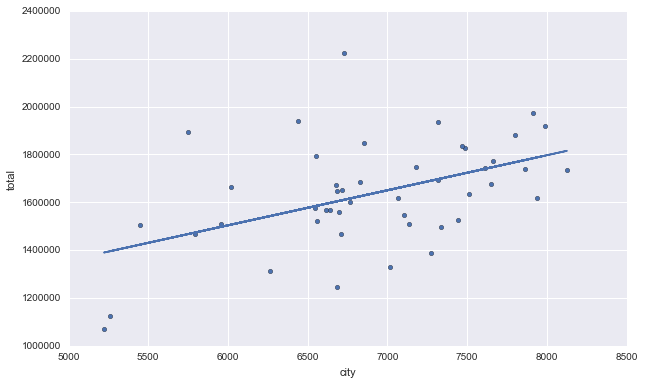

In [142]:
meter_records.plot(kind="scatter", x="city", y="total", figsize=(10, 6))
m, b = np.polyfit(meter_records.city, meter_records.total, 1)
plt.plot(meter_records.city, m*meter_records.city + b)

This is a medium correlation -- not great, but not bad. I don't have anything else to use, so let's go with it.

In [143]:
meter_records['adj_revenue'] = meter_records['total'] / meter_records['city']

In [144]:
meter_records.head()

,month,total,city,brinks,adj_revenue
0,1,2224277,6729,0,330.550899
1,2,1892672,5751,0,329.103113
2,3,1468074,6711,0,218.756370
3,4,1618966,7069,0,229.023341
4,5,1509195,7134,0,211.549622


Now let's see the mean adjusted revenue for months when Brinks was active (1) and not active (0).

In [145]:
meter_records.pivot_table(columns=['brinks'], values=['adj_revenue'])

brinks,0,1
adj_revenue,247.104317,229.583858


## The p-value

There's definitely a difference, but is it random chance or is this actually significant? In order to find out, we want the _p-value_.

What is a _p-value_?

For a test of statistical significance, we start with the _null hypothesis_. This is the hypothesis that there's no relation between groups. It's generally the opposite of what we're testing for. In this case, the null hypothesis is that there's no relation between whether Brinks was operating the meters and the amount of revenue brought in.

Once you have that, you compare your observed result -- in this case the difference in mean adjusted revenue for months when Brinks was active and when it was inactive -- to some statistical model to see how extreme your result is. Another way of looking at it is, given your observed result, what's the likelihood the null hypothesis is true?

People argue about the next step, but it's an OK rule of thumb: p-values of < 0.05 mean the null hypothesis is most likely not true.

Note that we never see the chance that our alternative hypothesis -- the thing we're testing for -- is true. We are accepting or rejecting the null hypothesis.

### Shuffling labels

There are complex formula-based ways to calculate the p-value. I don't know them. I have a computer, though, so I can use another way. We can shuffle the labels -- in this case, shuffle the "brinks" value to different months -- many times and record our results. Shuffling them assume they don't matter -- our null hypothesis. If we do this many times, we can get a distribution of results and then see where our observed result falls on that. I'm going to do this with Pandas, but there's other ways.

In [146]:
# Get our observed value.
def mean_revenue_diff(df):
    revenues = df.pivot_table(columns=['brinks'], values=['adj_revenue'])
    return (revenues[0] - revenues[1])['adj_revenue']

observed_mean_diff = mean_revenue_diff(meter_records)
observed_mean_diff

17.520458731191894

In [147]:
# Copy the table so we can mess with it.
mr2 = meter_records.copy()
mr2.head(10)

,month,total,city,brinks,adj_revenue
0,1,2224277,6729,0,330.550899
1,2,1892672,5751,0,329.103113
2,3,1468074,6711,0,218.756370
3,4,1618966,7069,0,229.023341
4,5,1509195,7134,0,211.549622
5,6,1511014,5954,0,253.781323
6,7,1506977,5447,0,276.661832
7,8,1520443,6558,0,231.845532
8,9,1070936,5222,0,205.081578
9,11,1602841,6765,0,236.931412


# Shuffle the Brinks column.

In [157]:
mr2.brinks = np.random.permutation(mr2.brinks)
mr2.pivot_table(columns=['brinks'], values=['adj_revenue'])

mean_revenue_diff(mr2)

20.518502959227476

In [158]:
num_experiments = 1000
results = []
count = 0
for _ in range(num_experiments):
    mr2.brinks = np.random.permutation(mr2.brinks)
    mean_diff = mean_revenue_diff(mr2)
    results.append(mean_diff)
    if observed_mean_diff >= 0 and mean_diff >= observed_mean_diff:
        count += 1
    elif observed_mean_diff < 0 and mean_diff <= observed_mean_diff:
        count += 1

In [159]:
print("Observed difference of two means: %.2f" % observed_mean_diff)
print(count, "out of", num_experiments, "experiments had a difference of two means ", end="")
if observed_mean_diff < 0:
    print("less than or equal to ", end="")
else:
    print("greater than or equal to ", end="")
print("%.2f" % observed_mean_diff, ".")
print("The chance of getting a difference of two means ", end="")
if observed_mean_diff < 0:
    print("less than or equal to ", end="")
else:
    print("greater than or equal to ", end="")
print("%.2f" % observed_mean_diff, "is", (count / float(num_experiments)), ".")

Observed difference of two means: 17.52
38 out of 1000 experiments had a difference of two means greater than or equal to 17.52 .
The chance of getting a difference of two means greater than or equal to 17.52 is 0.038 .


That's our p-value! Let's see it on a graph.

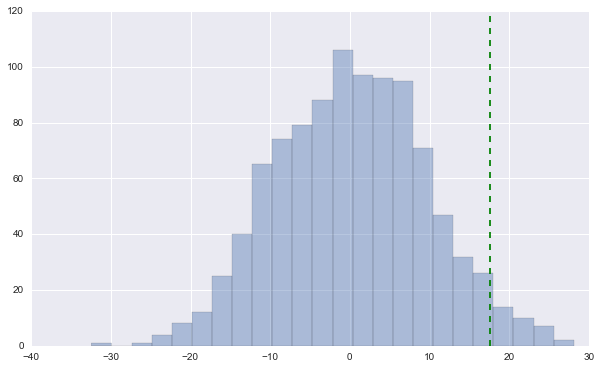

In [160]:
plt.figure(figsize=(10, 6))
sns.distplot(results, kde=False)
plt.vlines(observed_mean_diff, 0, 120, colors="g", linestyle="dashed")

## Confidence intervals

We'd like to know the amount of money Brinks owes the city, but there's not a good way to say exactly what that is. (Can you think of a way?)

Even though our results were statistically significant, they might not even be important. What if Brinks employees stole $100/month? To NYC, the costs of taking the case to trial would dwarf that. _Confidence intervals_ show us importance. A confidence interval is simply the range of likely results. In general, this is the middle 90% of possible values.

How do we get "possible values?" We can use a technique called "bootstrapping". We create samples of the data the same size as the original, taking observations randomly and _with replacement_. This means that we might pick the same observation more than once -- which is what we want. We do this 10,000 times, taking the difference of means each time.

In [163]:
meter_records.sample(n=10, replace=True)

,month,total,city,brinks,adj_revenue
18,20,1547011,7105,1,217.735538
28,30,1846508,6855,1,269.366594
40,42,1918247,7986,0,240.201227
30,32,1685611,6830,1,246.795168
22,24,1652490,6716,1,246.052710
13,15,1312257,6264,1,209.491858
38,40,1733339,8126,0,213.307778
34,36,1566107,6637,1,235.966099
38,40,1733339,8126,0,213.307778
34,36,1566107,6637,1,235.966099


In [164]:
conf_interval = 0.9
num_experiments = 1000
results = []
for _ in range(num_experiments):
    df = meter_records.sample(frac=1, replace=True)
    mean_diff = mean_revenue_diff(df)
    results.append(mean_diff)

In [165]:
results.sort()
tails = (1 - conf_interval) / 2
lower_bound = int(math.ceil(num_experiments * tails))
upper_bound = int(math.floor(num_experiments * (1 - tails)))

In [166]:
print("Observed difference between the means: %.2f" % observed_mean_diff)
print("We have %d%% confidence that the true difference between the means is between: %.2f and %.2f" % \
      (conf_interval * 100, results[lower_bound], results[upper_bound]))

Observed difference between the means: 17.52
We have 90% confidence that the true difference between the means is between: 2.99 and 32.11


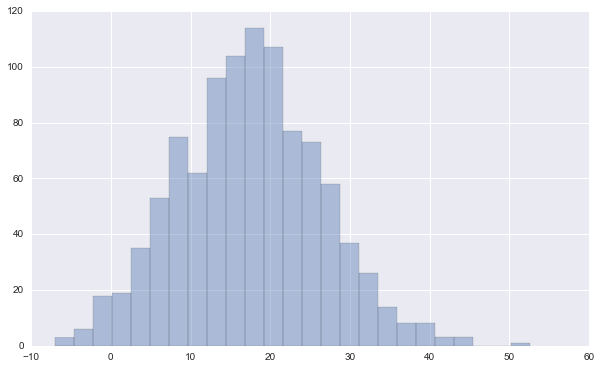

In [167]:
plt.figure(figsize=(10, 6))
sns.distplot(results, kde=False)

This doesn't get us an amount of dollars, though. How could we do that?

In [169]:
# Do amount of dollars calculations here.
meter_records[meter_records.brinks == 1].city.mean()

6933.75

In [170]:
print(2.99 * 6933.75)
print(32.11 * 6933.75)

20731.912500000002
222642.7125


In [171]:
len(meter_records[meter_records.brinks == 1])

24

## Resources

https://speakerdeck.com/jakevdp/statistics-for-hackers
http://www.amazon.com/Statistics-Edition-Synthesis-Lectures-Mathematics/dp/160845570X/ref=dp_ob_title_bk